<a href="https://colab.research.google.com/github/tjrgh822/class_itsystem/blob/master/hw4/Candle_stick_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from google.colab import drive
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%203years.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20corona-2.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20corona.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage-2.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage-3.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/KOSPI%20200%20Historical%20Data%20mortgage.csv
!wget https://raw.githubusercontent.com/tjrgh822/class_itsystem/master/hw4/TSEC%20Taiwan%2050%20Historical%20Data.csv


In [0]:

torch.manual_seed(0)

def investingcom_csv(dcsv):
  dcsv = dcsv[::-1]
  dcsv = dcsv[['Open', 'High', 'Low', "Vol.", 'Price', 'Change %' ]]
  dcsv['Vol.'] = dcsv['Vol.'].str.replace(pat='M', repl='e6', regex=False) 
  dcsv['Vol.'] = dcsv['Vol.'].str.replace(pat='K', repl='e3', regex=False)
  dcsv['Change %'] = dcsv['Change %'].astype(str).str.replace(pat='%', repl='', regex=False)

  dcsv['Open'] = dcsv['Open'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['High'] = dcsv['High'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['Low'] = dcsv['Low'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['Price'] = dcsv['Price'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['Vol.'] = dcsv['Vol.'].astype(str).str.replace(pat=',', repl='', regex=False)
  return dcsv

def yahoo_csv(dcsv):
  dcsv = dcsv[::-1]
  dcsv = dcsv[['Open', 'High', 'Low', "Volume", 'Close', 'Change %' ]]
  dcsv['Vol.'] = dcsv['Vol.'].str.replace(pat='M', repl='e6', regex=False) 
  dcsv['Vol.'] = dcsv['Vol.'].str.replace(pat='K', repl='e3', regex=False)
  dcsv['Change %'] = dcsv['Change %'].astype(str).str.replace(pat='%', repl='', regex=False)

  dcsv['Open'] = dcsv['Open'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['High'] = dcsv['High'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['Low'] = dcsv['Low'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['Price'] = dcsv['Price'].astype(str).str.replace(pat=',', repl='', regex=False)
  dcsv['Vol.'] = dcsv['Vol.'].astype(str).str.replace(pat=',', repl='', regex=False)
  return dcsv

#데이터 불러오기 -> investing.com 에서 historycal data로 불러왔다.

corona = pd.read_csv("KOSPI 200 Historical Data corona-2.csv")
corona = investingcom_csv(corona)

mortgage = pd.read_csv("KOSPI 200 Historical Data mortgage-3.csv")
mortgage = investingcom_csv(mortgage)


three_years = pd.read_csv("KOSPI 200 Historical Data 3years.csv")
three_years = investingcom_csv(three_years)

taiwan = pd.read_csv("TSEC Taiwan 50 Historical Data.csv")
taiwan = investingcom_csv(taiwan)

In [0]:
from mpl_finance import candlestick_ohlc
import matplotlib.gridspec as gridspec

from torch.utils.data import  TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

no_data_bias = False

def figure_to_array(fig):
    """
    plt.figure를 RGBA로 변환(layer가 4개)
    shape: height, width, layer
    """
    fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)

def csv_to_candlechart_numpy(csv, day_length):
  candle_data = csv
  labels = []
  images =  []
  for i in range(len(candle_data) - day_length):
    fig = plt.figure(figsize=(3,3), dpi=50)
    fig.set_facecolor('black')
    axes = []
    axes.append(plt.subplot())
    x = np.arange(day_length)
    ohlc = candle_data[['Open', 'High', 'Low', 'Price']].astype(float).values[i:i+day_length]
    dohlc = np.hstack((np.reshape(x, (-1, 1)), ohlc))
    
    # 봉차트
    candlestick_ohlc(axes[0], dohlc, width=0.5, colorup='r', colordown='b')
    plt.tight_layout()
    plt.axis('off')
    #print('2')


    #numpy 4dim
    fig.canvas.draw()
    _image = np.array(fig.canvas.renderer._renderer)
    images.append(_image)
    

    # labels
    fy = candle_data['Change %'].astype(np.float32).values[i+day_length]
    if fy > 0.5:
      _y = 2
    elif np.abs(np.array(fy)) < 0.2:
      _y = 1
    else:
      _y = 0
    labels.append(_y)

    plt.close(fig)


  return  images, np.array(labels).reshape(-1, 1), np.array(csv['Change %'].values.astype(float)).reshape(-1, 1)

if no_data_bias == True:

  class CustomDataset(Dataset): 
    def __init__(self, x_data, y_data, z_data, out_dim):

      self.xloader = transforms.Compose([ transforms.ToPILImage(), transforms.Resize(50),transforms.ToTensor()])
      self.out_dim = out_dim

      self.image = []
      self.label = []
      self.change = []
      #label에 따라서 이미지, 증가율 분류
      for i in range(out_dim):
        idx = np.where( y_data == i)[0]
        self.image.append(np.array( x_data)[idx])
        self.label.append( np.array( y_data)[idx] )
        self.change.append(np.array( z_data)[idx] )

    # 제일 작은 label의 갯수를 output dim에 곱해서 전체 데이터셋 갯수 반환
    def __len__(self):
      num = 100000
      for i in range(self.out_dim):
        if num > len(self.label[i]):
          num = len(self.label[i])
      return num * self.out_dim

    # idx를 받으면 몫, 나머지 구한후 image, label, change에 넣고 반환
    def __getitem__(self, idx):
      remain = idx % self.out_dim
      quot = idx // self.out_dim
      x = torch.FloatTensor( self.xloader(self.image[remain][quot]) ) / 255
      y = torch.squeeze(torch.LongTensor( self.label[remain][quot] ))
      z = self.change[remain][quot]
      return x, y, z
else:
  class CustomDataset(Dataset): 
    def __init__(self, x_data, y_data, z_data):
      self.x_data = x_data
      self.y_data = y_data
      self.xloader = transforms.Compose([ transforms.ToPILImage(), transforms.Resize(50),transforms.ToTensor()])
      self.z_data = z_data
    # 총 데이터의 개수를 리턴
    def __len__(self): 
      return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
      x = torch.FloatTensor( self.xloader(self.x_data[idx]) )
      y = torch.squeeze(torch.LongTensor( self.y_data[idx] ))
      z = self.z_data[idx]
      return x, y, z

In [0]:
# 데이터 선택 

seq_length = 10

DATASET = three_years

if type(DATASET) != 'string':
  trainX, trainY, train_change = csv_to_candlechart_numpy(DATASET.iloc[ : int(len(DATASET)*0.8) ], seq_length)
  testX, testY, test_change = csv_to_candlechart_numpy(DATASET.iloc[int(len(DATASET)*0.8) :  ], seq_length)

elif  DATASET is 'mortgage corona':
  DATASET_train = mortgage
  DATASET_test = corona

  trainX, trainY, train_change = csv_to_candlechart_numpy(DATASET_train, seq_length)
  testX, testY, test_change = csv_to_candlechart_numpy(DATASET_test, seq_length)



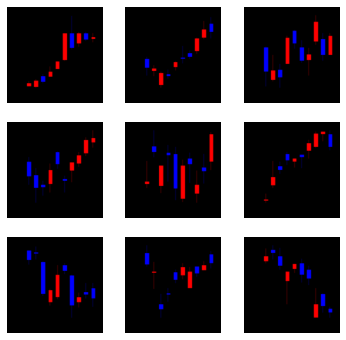

In [12]:
#custom data set으로 모든 label의 갯수를 동일하게 맞춤
trainset = CustomDataset(trainX, trainY, train_change[seq_length:])
testset = CustomDataset(testX, testY, test_change[seq_length:])

#실제 모델에 batch size로 data를 넣어줄 함수
trainloader = DataLoader(trainset, batch_size = 128, shuffle = False, num_workers= 1)
testloader = DataLoader(testset, batch_size = 128, shuffle = False, num_workers= 1)

plt.figure(figsize= (6, 6))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(trainX[i*10])
  plt.axis('off')
plt.show()

#print(trainset.__len__(), testset.__len__())

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#vgg make layer
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512, 1000),
            nn.RReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            nn.RReLU(),
            nn.Dropout(),
            nn.Linear(10, num_classes),
            nn.Softmax()
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 4

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.RReLU()]
            else:
                layers += [conv2d, nn.RReLU()]
            in_channels = v

    return nn.Sequential(*layers)
cfg = [32,32,'M', 64,64,'M',128,128,128,'M',256,256,256,'M',512,512,512,'M'] #13 + 3 =vgg16
vgg16= VGG(make_layers(cfg),2,True).to(device)

vgg_criterion = nn.CrossEntropyLoss().to(device)
vgg_optimizer = torch.optim.Adam(vgg16.parameters(), lr = 0.001)
vgg_lr_sche = optim.lr_scheduler.StepLR(vgg_optimizer, step_size=7, gamma=0.9)



In [14]:
epochs = 60

train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist, train_profit_hist, test_profit_hist = [], [], [], [], [], []
for epoch in range(epochs):  # loop over the dataset multiple times
    vgg_running_loss, train_acc, train_profit = [], [], 1
    vgg_lr_sche.step()
    vgg16.train()
    for inputs, labels, change in trainloader:
        # get the inputs
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        vgg_optimizer.zero_grad()
        # forward + backward + optimize
        vgg_outputs = vgg16(inputs)
        vgg_loss = vgg_criterion(vgg_outputs, labels)
        vgg_loss.backward()
        vgg_optimizer.step()
        # acc, loss, profit append
        vgg_outputs_cpu = vgg_outputs.to('cpu')
        acc = np.average(np.argmax(vgg_outputs_cpu.data.numpy(), axis =1) == labels.to('cpu').data.numpy())
        train_acc.append(acc)
        
        vgg_running_loss.append(np.average(vgg_loss.item()))

        for _p, _c in zip(np.argmax(vgg_outputs_cpu.data.numpy(), axis=1), change.data.numpy()):
              if _p == 2:
                output = (100 + _c)/100
              elif _p ==1:
                output = 1
              else:
                output = (100 - _c)/100
              train_profit *= output

    train_acc_hist.append( np.average(np.array(train_acc)) )
    train_loss_hist.append(np.average( np.array(vgg_running_loss)))
    train_profit_hist.append(float(train_profit))
    vgg16.eval()
    with torch.no_grad():
        vgg_test_loss, test_acc, test_profit = [], [], 1
        for inputs, labels, change in testloader:
            # get the inputs
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs.shape, labels.shape)

            # zero the parameter gradients
            vgg_optimizer.zero_grad()
            # forward
            vgg_outputs = vgg16(inputs)
            vgg_loss = vgg_criterion(vgg_outputs, labels)
            
            vgg_outputs_cpu = vgg_outputs.to('cpu')
            acc = np.average(np.argmax(vgg_outputs_cpu.data.numpy(), axis=1) == labels.to('cpu').data.numpy())
            test_acc.append(acc)
            vgg_test_loss.append(np.average(vgg_loss.item()) )
            for _p, _c in zip( np.argmax(vgg_outputs_cpu.data.numpy(), axis=1), change.data.numpy()):
              if _p == 2:
                output = (100 + _c)/100
              elif _p ==1:
                output = 1
              else:
                output = (100 - _c)/100
              test_profit *= output
              #print(output)
          
    test_acc_hist.append( np.average(np.array(test_acc)) )
    test_loss_hist.append(np.average(np.array(vgg_test_loss)))
    test_profit_hist.append(float(test_profit))
    if epoch % 10 == 0:
      print(f'epochs : {epoch +1}, loss : {train_loss_hist[-1]:.4} train_acc : {train_acc_hist[-1]:.4}, val_loss : {test_loss_hist[-1]:.4}', 
          f'val_acc : {test_acc_hist[-1]:.4}, train_profit : {train_profit_hist[-1]:.4} test_profit : {test_profit_hist[-1]:.4} ')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epochs : 1, loss : 1.449 train_acc : 0.5167, val_loss : -133.1 val_acc : 0.5231, train_profit : 1.088 test_profit : 0.9963 
epochs : 11, loss : 0.5457 train_acc : 0.5183, val_loss : 7.035e+04 val_acc : 0.5231, train_profit : 1.064 test_profit : 0.9963 
epochs : 21, loss : 0.5453 train_acc : 0.5183, val_loss : 7.351e+04 val_acc : 0.5231, train_profit : 1.044 test_profit : 0.9963 
epochs : 31, loss : 0.5441 train_acc : 0.5183, val_loss : 7.353e+04 val_acc : 0.5231, train_profit : 1.052 test_profit : 0.9963 
epochs : 41, loss : 0.5441 train_acc : 0.5183, val_loss : 7.353e+04 val_acc : 0.5231, train_profit : 1.044 test_profit : 0.9963 
epochs : 51, loss : 0.5441 train_acc : 0.5183, val_loss : 7.353e+04 val_acc : 0.5231, train_profit : 1.044 test_profit : 0.9963 


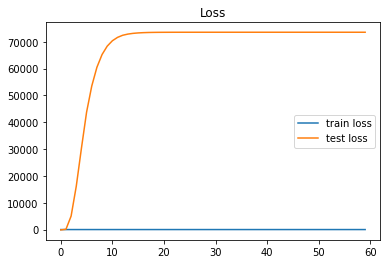

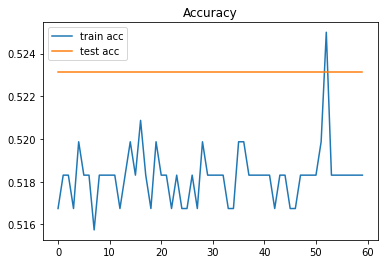

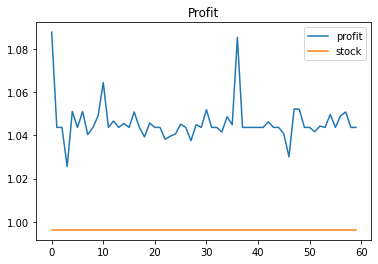

73527.76478220522


In [15]:
plt.figure()
plt.title('Loss')
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.legend(['train loss', 'test loss'])
plt.show()

plt.figure()
plt.title('Accuracy')
plt.plot(train_acc_hist)
plt.plot(test_acc_hist)
plt.legend(['train acc', 'test acc'])
plt.show()

plt.figure()
plt.title('Profit')
plt.plot(train_profit_hist)
plt.plot(test_profit_hist)
plt.legend(['profit', 'stock'])

plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


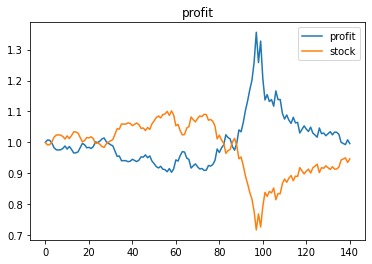

 총 수익률 : 0.9962997273266366


In [17]:
#profit 출력

with torch.no_grad():

    test_profit = 1
    price = 1
    #print(price)
    profit_hist, price_hist = np.zeros(1), np.zeros(1)
    for inputs, labels, change in testloader:
        # get the inputs
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print(inputs.shape, labels.shape)

        # zero the parameter gradients
        vgg_optimizer.zero_grad()
        # forward
        vgg_outputs = vgg16(inputs)
        vgg_loss = vgg_criterion(vgg_outputs, labels)
        
        vgg_outputs_cpu = vgg_outputs.to('cpu')
        acc = np.average(np.argmax(vgg_outputs_cpu.data.numpy(), axis=1) == labels.to('cpu').data.numpy())
        for _p, _c in zip( np.argmax(vgg_outputs_cpu.data.numpy(), axis=1), change.data.numpy()):
          if _p == 2:
            output = (100 + _c)/100
          elif _p ==1:
            output = 1
          else:
            output = (100 - _c)/100
          test_profit *= output
          profit_hist = np.append(profit_hist, np.array(test_profit))
          
          price *= (100 + _c)/100
          price_hist = np.append(price_hist, np.array(price))
    profit_hist = np.delete(profit_hist, 0)
    price_hist = np.delete(price_hist, 0)

    plt.figure()
    plt.title('profit')
    plt.plot(profit_hist)
    plt.plot(np.array(price_hist).reshape(-1))
    plt.legend(['profit', 'stock'])
    plt.show()

    print(f' 총 수익률 : {profit_hist[-1]}')